In [17]:
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm
import cv2
import os
import seaborn as sns
# import tensorflow as tf
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# from keras.models import Sequential, Model
# from keras.layers import Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose
# from keras.layers import Activation, LeakyReLU, BatchNormalization, Dropout, Resizing
# from keras.losses import BinaryCrossentropy
# from tensorflow.keras.applications import VGG16

# try:
#     from tensorflow.keras.optimizers import Adam
# except:
#     from keras.optimizers import Adam

import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

In [18]:
NOISE_DIM = 100  
BATCH_SIZE = 4
EPOCHS = 10000
SEED = 40
WIDTH, HEIGHT, CHANNELS = 128, 128, 1


In [19]:
MAIN_DIR = "./yes"

In [20]:
class DCGAN_Dataset(Dataset):
    def __init__(self, transform):
        self.transform = transform
        self.image_folder = os.listdir('./yes')
        
    def __len__(self):
        return len(self.image_folder)
    
    def __getitem__(self, idx):
        img_path = self.image_folder[idx]
        img = cv2.imread('./yes/'+img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (128, 128))
        img = self.transform(img)
        
        label = 1
        
        return (img, label)
        

In [21]:
train_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5), (0.5))])

In [22]:
train_set = DCGAN_Dataset(transform=train_transforms)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

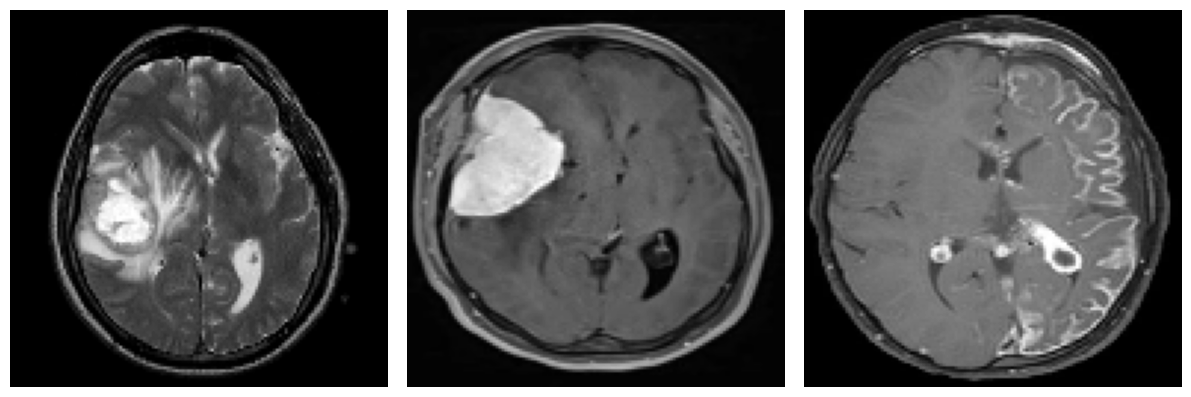

In [23]:
plt.figure(figsize=(20,8))
for x, y in train_loader:
    for i in range(3):
        axs = plt.subplot(2,5,i+1)
        plt.imshow(x[i].reshape(WIDTH, HEIGHT,CHANNELS), cmap="gray")
        plt.axis('off')
        axs.set_xticklabels([])
        axs.set_yticklabels([])
        plt.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()

In [24]:
class Generator(nn.Module):
    def __init__(self, NOISE_DIM):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(NOISE_DIM, 32*32*256)
        self.dconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.dconv2 = nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.Conv2d(128, 1, kernel_size=3, stride=1, padding=1)
        
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.2)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        x = self.leakyrelu(self.fc1(x))
        x = x.unflatten(-1,(256, 32, 32))
        # print(x.shape)
        x = self.leakyrelu(self.dconv1(x))
        # print(x.shape)
        x = self.leakyrelu(self.dconv2(x))
        # print(x.shape)
        x = self.tanh(self.conv1(x))
        # print(x.shape)
        return x
        

In [25]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.4)
        
        self.fc1 = nn.Linear(65536,1)
        
        self.leakyrelu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.leakyrelu(self.conv1(x))
        x = self.leakyrelu(self.conv2(x))
        x = self.leakyrelu(self.conv3(x))
        x = self.leakyrelu(self.conv4(x))
        # print(x.shape)
        x = self.flatten(x)
        x = self.dropout(x)
        # print(x.shape)
        x = self.sigmoid(self.fc1(x))
        
        return x

In [26]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [27]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

G = Generator(NOISE_DIM).to(device)
D = Discriminator().to(device)

G.apply(weights_init)
D.apply(weights_init)

Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=65536, out_features=1, bias=True)
  (leakyrelu): LeakyReLU(negative_slope=0.2)
  (sigmoid): Sigmoid()
)

In [29]:
criterion = nn.BCELoss()
lrD = 0.0002
lrG = 0.0001
optimizerD = optim.Adam(D.parameters(), lr=lrD, betas=(0.5, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=lrG, betas=(0.5, 0.999))

In [30]:
from torchsummary import summary
summary(G, (NOISE_DIM,), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 262144]      26,476,544
         LeakyReLU-2               [-1, 262144]               0
   ConvTranspose2d-3          [-1, 128, 64, 64]         524,416
         LeakyReLU-4          [-1, 128, 64, 64]               0
   ConvTranspose2d-5        [-1, 128, 128, 128]         262,272
         LeakyReLU-6        [-1, 128, 128, 128]               0
            Conv2d-7          [-1, 1, 128, 128]           1,153
              Tanh-8          [-1, 1, 128, 128]               0
Total params: 27,264,385
Trainable params: 27,264,385
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 44.25
Params size (MB): 104.01
Estimated Total Size (MB): 148.26
----------------------------------------------------------------


In [31]:
summary(D, (1,128,128), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             640
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]          73,856
         LeakyReLU-4          [-1, 128, 64, 64]               0
            Conv2d-5          [-1, 128, 32, 32]         147,584
         LeakyReLU-6          [-1, 128, 32, 32]               0
            Conv2d-7          [-1, 256, 16, 16]         295,168
         LeakyReLU-8          [-1, 256, 16, 16]               0
           Flatten-9                [-1, 65536]               0
          Dropout-10                [-1, 65536]               0
           Linear-11                    [-1, 1]          65,537
          Sigmoid-12                    [-1, 1]               0
Total params: 582,785
Trainable params: 582,785
Non-trainable params: 0
-------------------------------

[0/10000][38/39]  Loss_D: 0.0111  Loss_G: 5.9802


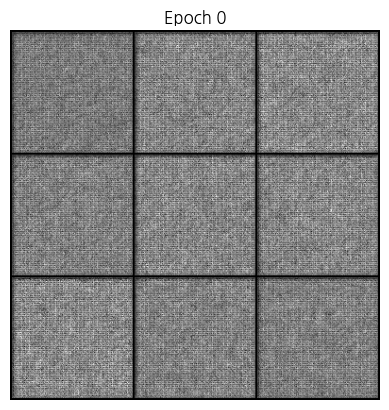

[1000/10000][38/39]  Loss_D: 100.0000  Loss_G: 0.0000


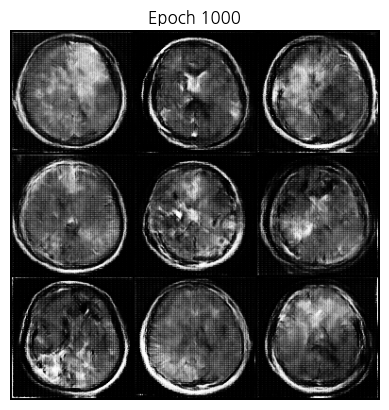

[2000/10000][38/39]  Loss_D: 100.0000  Loss_G: 0.0000


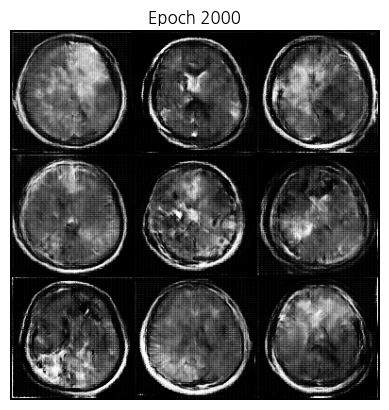

[3000/10000][38/39]  Loss_D: 100.0000  Loss_G: 0.0000


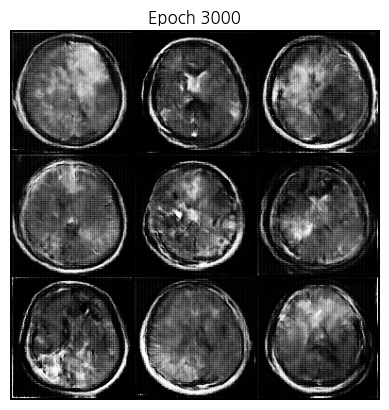

[4000/10000][38/39]  Loss_D: 100.0000  Loss_G: 0.0000


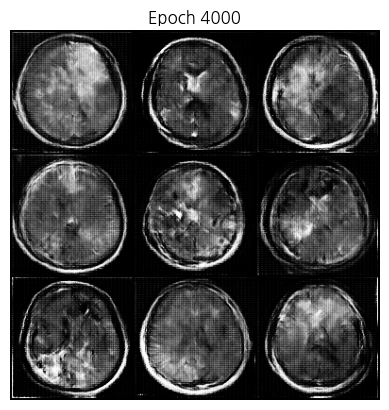

[5000/10000][38/39]  Loss_D: 100.0000  Loss_G: 0.0000


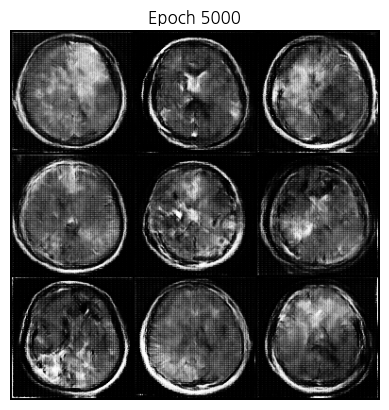

[6000/10000][38/39]  Loss_D: 100.0000  Loss_G: 0.0000


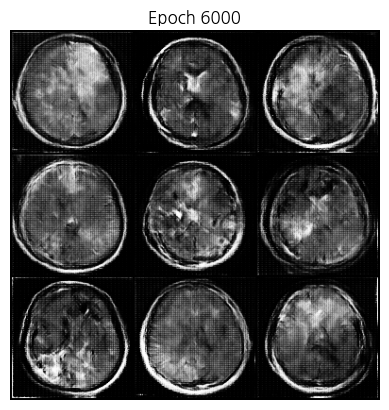

[7000/10000][38/39]  Loss_D: 100.0000  Loss_G: 0.0000


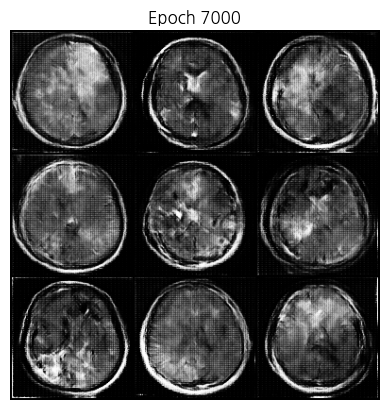

[8000/10000][38/39]  Loss_D: 100.0000  Loss_G: 0.0000


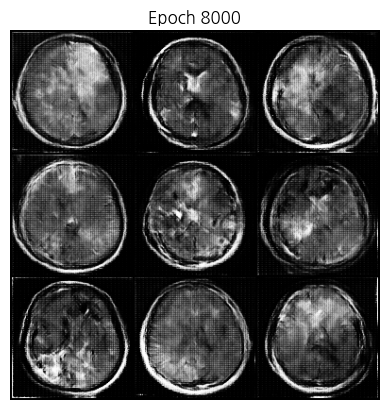

[9000/10000][38/39]  Loss_D: 100.0000  Loss_G: 0.0000


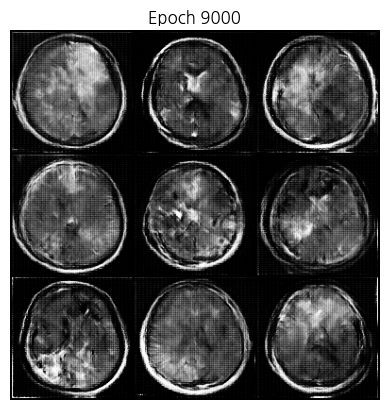

In [32]:
fixed_noise = torch.randn(9, NOISE_DIM, device=device)
import torchvision.utils as vutils


# -------------------
# Training Loop
# -------------------
for epoch in range(EPOCHS):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        # print(real_images.shape)
        b_size = real_images.size(0)
        real_labels = torch.ones(b_size, device=device)
        fake_labels = torch.zeros(b_size, device=device)

        # ---- Train Discriminator ----
        D.zero_grad()
        output_real = D(real_images).view(-1)
        lossD_real = criterion(output_real, real_labels)

        noise = torch.randn(b_size, NOISE_DIM, device=device)
        fake_images = G(noise)
        # print(fake_images.shape)
        # print(real_images.shape)
        output_fake = D(fake_images.detach()).view(-1)
        lossD_fake = criterion(output_fake, fake_labels)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        # ---- Train Generator ----
        G.zero_grad()
        output_fake_for_G = D(fake_images).view(-1)
        lossG = criterion(output_fake_for_G, real_labels)  # Generator wants D(fake) == real
        lossG.backward()
        optimizerG.step()

    if epoch%1000==0:
        print(f"[{epoch}/{EPOCHS}][{i}/{len(train_loader)}]  Loss_D: {lossD.item():.4f}  Loss_G: {lossG.item():.4f}")
        # Save generated images
        with torch.no_grad():
            fake = G(fixed_noise).detach().cpu()
        grid = vutils.make_grid(fake, nrow=3, padding=2, normalize=True)
        plt.imshow(grid.permute(1, 2, 0))
        plt.title(f"Epoch {epoch}")
        plt.axis('off')
        plt.show()

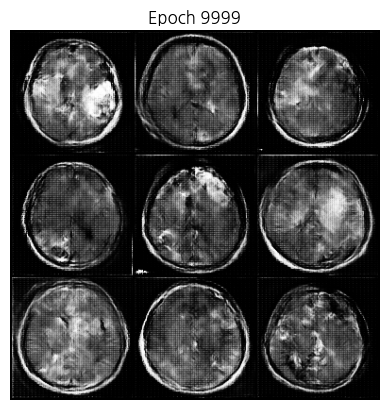

In [37]:
noise = torch.randn(9, NOISE_DIM, device=device)

with torch.no_grad():
    fake = G(noise).detach().cpu()
    grid = vutils.make_grid(fake, nrow=3, padding=2, normalize=True)
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(f"Epoch {epoch}")
    plt.axis('off')
    plt.show()

torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])


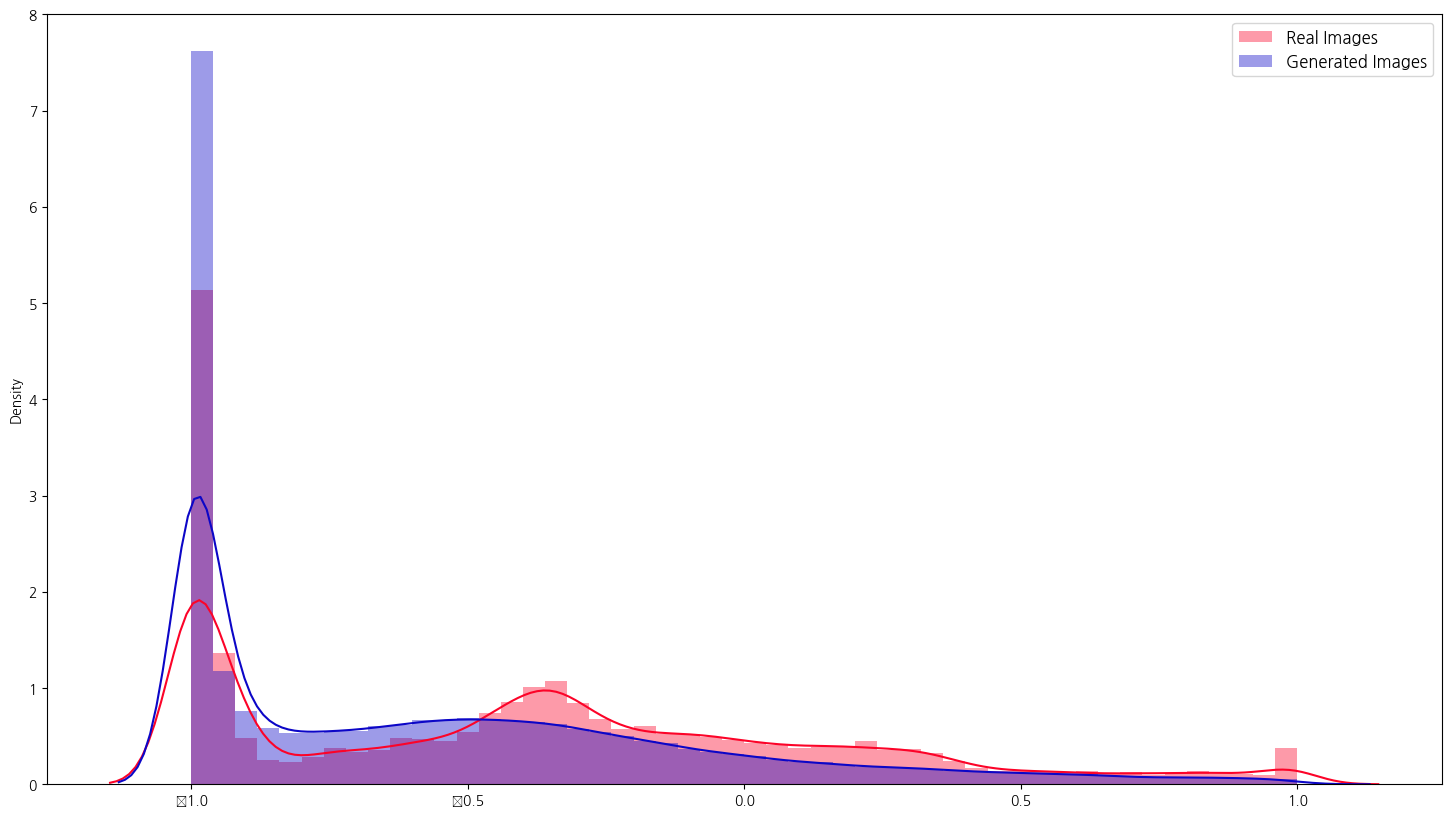

In [46]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(18,10))
x = []
for xt, _ in train_loader:
    x.extend(xt)
x = torch.stack(x[:9])
print(x.shape)
print(fake.shape)
sns.distplot(x, label='Real Images', hist=True, color='#fc0328', ax=axs)
sns.distplot(fake, label='Generated Images', hist=True, color='#0c06c7', ax=axs)

axs.legend(loc='upper right', prop={'size': 12})

plt.show()

In [50]:
from torchvision.utils import save_image

# os.makedirs('yes_G')
noise = torch.randn(200, NOISE_DIM, device=device)
with torch.no_grad():
    fake = G(noise).detach().cpu()
print(fake.shape)

for i in range(fake.size(0)):
    save_image(fake[i], f"yes_G/fake{i:03d}.jpg", normalize=True)

torch.Size([200, 1, 128, 128])
